# Modelo Not BIO bilstm2-dropout0.3-dense-adam-sigmoid

In [1]:
MODELO = "bilstm2_dropout0.3_dense_rmsprop"
LABELS = ["NADA",
          "B-CENTRO", "I-CENTRO", "B-CONTACTO", "B-DIRECCION", "I-DIRECCION", "B-HISTORIA", 
          "B-IDENT", "I-IDENT", "B-PERSONA", "I-PERSONA", "B-REFERENCIA", "B-UBICACION", "I-UBICACION"]

model = "bio-noda-bilstm2"

## Imports

In [2]:
import os
import json
import logging
import argparse
import pandas as pd
import numpy as np
import seaborn as sbn

from pathlib import Path
from sklearn import metrics
from IPython.display import display
from matplotlib import pyplot as plt

from galennlp_keras_utils.sequences import (
    GeneratorConf,
    multilabel,
)

In [3]:
# Avoid printing warnings.
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow
from tensorflow.keras import models as k_models
from tensorflow.keras import layers as k_layers
from tensorflow.keras import metrics as k_metrics
from keras.callbacks import ModelCheckpoint
from tensorflow.train import latest_checkpoint as latest_checkpoint
from tensorflow.keras.callbacks import CSVLogger

print(tensorflow.__version__)

if tensorflow.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
else:
    print("The installed version of TensorFlow does not include GPU support.")

print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

2.10.0-dev20220404
The installed version of TensorFlow includes GPU support.
Num GPUs Available:  1


## Random seeds

In [4]:
import random

seed = 12345

tensorflow.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Workspace Directions

In [5]:
# Workspace.
workspace_dir = os.path.abspath('') + '\\'
print(workspace_dir)

# Results.
results_dir = workspace_dir + 'results_guille-bio\\' + model + '\\'
Path(results_dir).mkdir(exist_ok=True)
print(results_dir)

# Data.
data_dir = 'C:\\Galen\\galen_guille\\bio-bin\\'
Path(data_dir).mkdir(exist_ok=True)
print(data_dir)

# Model.
model_dir = workspace_dir + 'models_galen\\' + model + '\\'
Path(model_dir).mkdir(exist_ok=True)
print(model_dir)

D:\Galen\deidentificacion\
D:\Galen\deidentificacion\results_guille-bio\bio-noda-bilstm2\
C:\Galen\galen_guille\bio-bin\
D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\


## Etiquetas

In [6]:
with open(data_dir +'etiquetas-bio.txt', 'r') as file:
    print (file.read())

O
B-CENTRO
I-CENTRO
B-CONTACTO
B-DIRECCION
I-DIRECCION
B-HISTORIA
B-IDENT
I-IDENT
B-PERSONA
I-PERSONA
B-REFERENCIA
B-UBICACION
I-UBICACION



## Construir Modelo

In [7]:
def build_model(n_features, n_classes, mask_value):
    "build keras model"
    model = k_models.Sequential([
        k_layers.Masking(mask_value=mask_value, input_shape=(None, n_features)),
        k_layers.Bidirectional(k_layers.LSTM(64, dropout=0.3, return_sequences=True)),
        k_layers.Bidirectional(k_layers.LSTM(32, dropout=0.2, return_sequences=True)),
        k_layers.TimeDistributed(k_layers.Dense(16, activation="relu")),
        k_layers.TimeDistributed(k_layers.Dense(n_classes, activation="sigmoid"))
    ])
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=[
            k_metrics.CategoricalAccuracy(),
            k_metrics.AUC(curve="PR", name="auc_pr"),
            k_metrics.Precision(),
            k_metrics.Recall()
        ]
    )
    display(model.summary())
    return model

## Configuración Entrenamiento

In [8]:
args_train = [
    Path(data_dir + 'train.npy'),
]
args_valid = [
    Path(data_dir + 'val.npy')
]
args_test = [
    Path(data_dir + 'test.npy')
]

args_conf = Path(model_dir + 'conf_galen.json')
with open(args_conf) as fd_conf:
    settings = json.load(fd_conf)

eval_settings = settings.get("eval", {})
    
mask_value = settings['generator']['mask_value']
batch_size = settings['generator']['batch_size']
epochs = settings['generator']['epochs']

ref_metric = eval_settings.get("metric", "f1_samples")
patience = eval_settings.get("early_stop", None)
threshold = eval_settings.get("threshold", 0.5)

print("CONFIG:")
print("epochs:", str(epochs))
print("batch_size:", str(batch_size))
print("mask_value:", str(mask_value))
print("onehot:", str(settings['generator']['onehot']))
print("is_weighted:", str(settings['generator']['is_weighted']))
print("metric:", str(ref_metric))
print("early_stop:", str(patience))
print("threshold:", str(threshold))

classes = settings['data']['classes']
null_class = None #settings['data']['null_class']

print()
print("DATA:")
print("classes:", len(classes))
print("null class:", null_class)
print("tags:")
for idx, tag in enumerate(classes):
    print("%d: %s" % (idx, tag))

CONFIG:
epochs: 500
batch_size: 64
mask_value: -99
onehot: True
is_weighted: True
metric: f1_macro
early_stop: 75
threshold: 0.5

DATA:
classes: 14
null class: None
tags:
0: O
1: B-CENTRO
2: I-CENTRO
3: B-CONTACTO
4: B-DIRECCION
5: I-DIRECCION
6: B-HISTORIA
7: B-IDENT
8: I-IDENT
9: B-PERSONA
10: I-PERSONA
11: B-REFERENCIA
12: B-UBICACION
13: I-UBICACION


## Función de Evaluación

In [9]:
def evaluar_red(network, testgen, null_class, threshold=0.5):
    """evaluar la red con el generador de test proporcionado

    network - keras model
    testgen - dataset iterator
    null_class - índice de la clase nula (o None)
    """
    prediccion = testgen.predict(network)
    # print(prediccion.shape)
    p_prob = prediccion[:, 0, :]
    p_pred = (p_prob > threshold) + 0.0
    p_true = prediccion[:, 1, :]
    valid_labels = list(range(p_true.shape[-1]))
    if null_class is not None:
        valid_labels = [x for x in valid_labels if x != null_class]
    m_micro = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="micro",
        zero_division=0
    )
    m_macro = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="macro",
        zero_division=0
    )
    m_samples = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="samples",
        zero_division=0
    )
    out = {
        # "roc_auc_macro": metrics.roc_auc_score(p_true, p_prob, average="macro"),
        # "roc_auc_micro": metrics.roc_auc_score(p_true, p_prob, average="micro"),
        "pr_auc_macro": metrics.average_precision_score(p_true, p_prob, average="macro"),
        "pr_auc_micro": metrics.average_precision_score(p_true, p_prob, average="micro"),
        "f1_micro": m_micro[2],
        "f1_macro": m_macro[2],
        "f1_samples": m_samples[2],
        "precision_micro": m_micro[0],
        "precision_macro": m_macro[0],
        "precision_samples": m_samples[0],
        "recall_micro": m_micro[1],
        "recall_macro": m_macro[1],
        "recall_samples": m_samples[1],
    }
    return out, prediccion

## Crear generadores de datos

In [10]:
gen_conf = GeneratorConf(**settings["generator"])
display(gen_conf)

gen_train = multilabel.MultiLabelTrainSequence(args_train, gen_conf)
gen_valid = multilabel.MultiLabelTrainSequence(args_valid, gen_conf)
gen_test = multilabel.MultiLabelTrainSequence(args_test, gen_conf)

features = gen_train.manifest().input_segment.size()
classes = gen_train.manifest().output_segment.size()

print()
print("Pesos de clases")
display(gen_train.pseudo_class_weights)

print()
print("FEATURES:", features)
print("CLASSES:", classes)
print("TAGS:")
for idx, tag in sorted(gen_train.manifest().tags.items()):
    print("%02d: %s" % (idx, tag))

GeneratorConf(batch_size=64, epochs=500, onehot=True, exclusive_onehot=False, is_weighted=True, mask_value=-99, classes=None, null_class=None, flatten=False)


Pesos de clases


{0: 0.07184551314938423,
 1: 98.70268620268621,
 2: 27.188262002858824,
 3: 1074.252491694352,
 4: 23096.428571428572,
 5: 4199.350649350649,
 6: 2566.2698412698414,
 7: 733.219954648526,
 8: 1443.5267857142858,
 9: 105.70447858777378,
 10: 206.21811224489795,
 11: 334.7308488612836,
 12: 135.4629241726016,
 13: 166.76121712222795}


FEATURES: 416
CLASSES: 14
TAGS:
00: O
01: B-CENTRO
02: I-CENTRO
03: B-CONTACTO
04: B-DIRECCION
05: I-DIRECCION
06: B-HISTORIA
07: B-IDENT
08: I-IDENT
09: B-PERSONA
10: I-PERSONA
11: B-REFERENCIA
12: B-UBICACION
13: I-UBICACION


## Crear Modelo

In [11]:
red = build_model(features, classes, mask_value=mask_value)

checkpoint_path = model_dir + 'model_checkpoint.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor="val_recall",
                              mode="max",
                              verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 416)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        246272    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         41216     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, None, 16)         1040      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 14)         238       
 tributed)                                              

None

## Entrenar Modelo

In [12]:
def train():
    # save tags
    with open(results_dir + 'etiquetas.txt', 'wt') as fd_lbl:
        for _, tag in sorted(gen_train.manifest().tags.items()):
            print(tag, file=fd_lbl)
            
    history = {}
    metricas = []
    best_idx = 0
    best_ref_value = -1
    best_prediction = None
    for idx in range(epochs):
        if patience is not None:
            print(f"epoch {idx} / {epochs} (patience {idx - best_idx} / {patience})")
        else:
            print(f"epoch {idx} / {epochs}")
            
        ep_history = red.fit(
            gen_train,
            batch_size=batch_size,
            epochs=1,
            validation_data=gen_valid,
            callbacks=[cp_callback],
            verbose=1
        )
        red.save(str(results_dir + 'final_model.h5'))
        
        for k, v in ep_history.history.items():
            if k not in history:
                history[k] = []
            history[k].extend(v)

        # evaluación de medidas para todo el conjunto de validacion
        # para evitar promedio por batch
        values, prediction = evaluar_red(red, gen_valid, null_class, threshold)
        ref_value = values[ref_metric]
        if ref_value > best_ref_value:
            best_ref_value = ref_value
            best_idx = idx
            best_prediction = prediction
            print('Mejor valor ', ref_metric, best_ref_value)
            red.save(str(results_dir + 'best_model.h5'))

        prediction = None
        metricas.append(values)
        
        if idx and (patience is not None) and ((idx - best_idx) > patience):
            print(f"Paciencia agotada tras {patience} épocas")
            break

    print('Mejor %s de validación en epoch %d' % (ref_metric, best_idx))

    history = pd.DataFrame(history)
    metricas = pd.DataFrame(metricas)

    np.save(str(results_dir + 'best_prediction.npy'), best_prediction)
    history.to_csv(results_dir + 'history.csv')
    metricas.to_csv(results_dir + 'metricas.csv')
    np.save(str(results_dir + 'best_idx.npy'), best_idx)
    
train()

epoch 0 / 500 (patience 0 / 75)
324/324 [==============================] - ETA: 0s - loss: 0.0476 - categorical_accuracy: 0.8684 - auc_pr: 0.4146 - precision: 0.4372 - recall: 0.1994
Epoch 1: val_recall improved from -inf to 0.35484, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\model_checkpoint.ckpt
324/324 [==============================] - 42s 83ms/step - loss: 0.0476 - categorical_accuracy: 0.8684 - auc_pr: 0.4146 - precision: 0.4372 - recall: 0.1994 - val_loss: 0.0313 - val_categorical_accuracy: 0.9512 - val_auc_pr: 0.9573 - val_precision: 1.0000 - val_recall: 0.3548
Mejor valor  f1_macro 0.03758407017743127
epoch 1 / 500 (patience 1 / 75)
324/324 [==============================] - ETA: 0s - loss: 0.0338 - categorical_accuracy: 0.8900 - auc_pr: 0.9319 - precision: 0.9998 - recall: 0.4624
Epoch 1: val_recall improved from 0.35484 to 0.84659, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\model_checkpoint.ckpt
324/324 [=============

epoch 14 / 500 (patience 2 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0059 - categorical_accuracy: 0.9845 - auc_pr: 0.9938 - precision: 0.9880 - recall: 0.9789
Epoch 1: val_recall did not improve from 0.98180
324/324 [==============================] - 22s 68ms/step - loss: 0.0058 - categorical_accuracy: 0.9844 - auc_pr: 0.9938 - precision: 0.9880 - recall: 0.9788 - val_loss: 0.0125 - val_categorical_accuracy: 0.9855 - val_auc_pr: 0.9938 - val_precision: 0.9885 - val_recall: 0.9814
Mejor valor  f1_macro 0.38496591180246315
epoch 15 / 500 (patience 1 / 75)
324/324 [==============================] - ETA: 0s - loss: 0.0055 - categorical_accuracy: 0.9855 - auc_pr: 0.9943 - precision: 0.9890 - recall: 0.9807
Epoch 1: val_recall improved from 0.98180 to 0.98666, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\model_checkpoint.ckpt
324/324 [==============================] - 22s 68ms/step - loss: 0.0055 - categorical_accuracy: 0.9855 - auc_pr: 0.9

324/324 [==============================] - 22s 67ms/step - loss: 0.0020 - categorical_accuracy: 0.9945 - auc_pr: 0.9979 - precision: 0.9956 - recall: 0.9923 - val_loss: 0.0148 - val_categorical_accuracy: 0.9919 - val_auc_pr: 0.9963 - val_precision: 0.9938 - val_recall: 0.9887
epoch 29 / 500 (patience 4 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0023 - categorical_accuracy: 0.9946 - auc_pr: 0.9978 - precision: 0.9958 - recall: 0.9927
Epoch 1: val_recall did not improve from 0.99356
324/324 [==============================] - 22s 67ms/step - loss: 0.0023 - categorical_accuracy: 0.9946 - auc_pr: 0.9978 - precision: 0.9957 - recall: 0.9927 - val_loss: 0.0158 - val_categorical_accuracy: 0.9941 - val_auc_pr: 0.9974 - val_precision: 0.9956 - val_recall: 0.9919
epoch 30 / 500 (patience 5 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0018 - categorical_accuracy: 0.9950 - auc_pr: 0.9980 - precision: 0.9960 - recall: 0.9933
Epoch 1: val_recall improved 

epoch 43 / 500 (patience 3 / 75)
323/324 [============================>.] - ETA: 0s - loss: 6.9626e-04 - categorical_accuracy: 0.9977 - auc_pr: 0.9989 - precision: 0.9980 - recall: 0.9970
Epoch 1: val_recall improved from 0.99691 to 0.99716, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\model_checkpoint.ckpt
324/324 [==============================] - 22s 69ms/step - loss: 6.9414e-04 - categorical_accuracy: 0.9977 - auc_pr: 0.9989 - precision: 0.9980 - recall: 0.9970 - val_loss: 0.0202 - val_categorical_accuracy: 0.9976 - val_auc_pr: 0.9985 - val_precision: 0.9979 - val_recall: 0.9972
epoch 44 / 500 (patience 4 / 75)
324/324 [==============================] - ETA: 0s - loss: 4.5122e-04 - categorical_accuracy: 0.9979 - auc_pr: 0.9990 - precision: 0.9983 - recall: 0.9971
Epoch 1: val_recall did not improve from 0.99716
324/324 [==============================] - 22s 69ms/step - loss: 4.5122e-04 - categorical_accuracy: 0.9979 - auc_pr: 0.9990 - precision: 0.9983 - 

324/324 [==============================] - ETA: 0s - loss: 2.6585e-04 - categorical_accuracy: 0.9985 - auc_pr: 0.9993 - precision: 0.9988 - recall: 0.9980
Epoch 1: val_recall improved from 0.99806 to 0.99812, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\model_checkpoint.ckpt
324/324 [==============================] - 22s 68ms/step - loss: 2.6585e-04 - categorical_accuracy: 0.9985 - auc_pr: 0.9993 - precision: 0.9988 - recall: 0.9980 - val_loss: 0.0199 - val_categorical_accuracy: 0.9985 - val_auc_pr: 0.9989 - val_precision: 0.9987 - val_recall: 0.9981
epoch 58 / 500 (patience 6 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.1461e-04 - categorical_accuracy: 0.9988 - auc_pr: 0.9994 - precision: 0.9990 - recall: 0.9984
Epoch 1: val_recall did not improve from 0.99812
324/324 [==============================] - 22s 67ms/step - loss: 1.1426e-04 - categorical_accuracy: 0.9988 - auc_pr: 0.9994 - precision: 0.9990 - recall: 0.9984 - val_loss: 0.0184

epoch 72 / 500 (patience 10 / 75)
324/324 [==============================] - ETA: 0s - loss: 8.5284e-05 - categorical_accuracy: 0.9992 - auc_pr: 0.9996 - precision: 0.9993 - recall: 0.9990
Epoch 1: val_recall improved from 0.99852 to 0.99870, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\model_checkpoint.ckpt
324/324 [==============================] - 22s 68ms/step - loss: 8.5284e-05 - categorical_accuracy: 0.9992 - auc_pr: 0.9996 - precision: 0.9993 - recall: 0.9990 - val_loss: 0.0226 - val_categorical_accuracy: 0.9988 - val_auc_pr: 0.9990 - val_precision: 0.9989 - val_recall: 0.9987
epoch 73 / 500 (patience 11 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.2117e-04 - categorical_accuracy: 0.9993 - auc_pr: 0.9997 - precision: 0.9993 - recall: 0.9991
Epoch 1: val_recall did not improve from 0.99870
324/324 [==============================] - 22s 67ms/step - loss: 1.2079e-04 - categorical_accuracy: 0.9993 - auc_pr: 0.9997 - precision: 0.9993 

epoch 87 / 500 (patience 3 / 75)
323/324 [============================>.] - ETA: 0s - loss: 5.7958e-05 - categorical_accuracy: 0.9996 - auc_pr: 0.9998 - precision: 0.9996 - recall: 0.9995
Epoch 1: val_recall did not improve from 0.99897
324/324 [==============================] - 22s 68ms/step - loss: 5.7791e-05 - categorical_accuracy: 0.9996 - auc_pr: 0.9998 - precision: 0.9996 - recall: 0.9995 - val_loss: 0.0210 - val_categorical_accuracy: 0.9987 - val_auc_pr: 0.9989 - val_precision: 0.9988 - val_recall: 0.9985
epoch 88 / 500 (patience 4 / 75)
324/324 [==============================] - ETA: 0s - loss: 7.3493e-05 - categorical_accuracy: 0.9995 - auc_pr: 0.9997 - precision: 0.9996 - recall: 0.9993
Epoch 1: val_recall did not improve from 0.99897
324/324 [==============================] - 22s 67ms/step - loss: 7.3493e-05 - categorical_accuracy: 0.9995 - auc_pr: 0.9997 - precision: 0.9996 - recall: 0.9993 - val_loss: 0.0186 - val_categorical_accuracy: 0.9986 - val_auc_pr: 0.9989 - val_pre

epoch 103 / 500 (patience 19 / 75)
324/324 [==============================] - ETA: 0s - loss: 8.1029e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9997 - recall: 0.9996
Epoch 1: val_recall did not improve from 0.99899
324/324 [==============================] - 22s 67ms/step - loss: 8.1029e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9997 - recall: 0.9996 - val_loss: 0.0258 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9989 - val_precision: 0.9991 - val_recall: 0.9988
epoch 104 / 500 (patience 20 / 75)
324/324 [==============================] - ETA: 0s - loss: 9.8962e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9997
Epoch 1: val_recall improved from 0.99899 to 0.99903, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\model_checkpoint.ckpt
324/324 [==============================] - 23s 69ms/step - loss: 9.8962e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9999 - precision: 0.999

323/324 [============================>.] - ETA: 0s - loss: 7.9421e-05 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9998
Epoch 1: val_recall did not improve from 0.99906
324/324 [==============================] - 22s 67ms/step - loss: 7.9183e-05 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.0298 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9990 - val_precision: 0.9992 - val_recall: 0.9989
epoch 119 / 500 (patience 15 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.0430e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9997
Epoch 1: val_recall did not improve from 0.99906
324/324 [==============================] - 22s 67ms/step - loss: 1.0397e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9997 - val_loss: 0.0273 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9990 - val_precision: 0.9991 - val_recall: 0.

324/324 [==============================] - ETA: 0s - loss: 1.7986e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9997
Epoch 1: val_recall did not improve from 0.99912
324/324 [==============================] - 22s 67ms/step - loss: 1.7986e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9997 - val_loss: 0.0299 - val_categorical_accuracy: 0.9992 - val_auc_pr: 0.9990 - val_precision: 0.9992 - val_recall: 0.9990
epoch 134 / 500 (patience 4 / 75)
324/324 [==============================] - ETA: 0s - loss: 1.0020e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9997
Epoch 1: val_recall did not improve from 0.99912
324/324 [==============================] - 22s 67ms/step - loss: 1.0020e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9997 - val_loss: 0.0290 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9

epoch 149 / 500 (patience 19 / 75)
324/324 [==============================] - ETA: 0s - loss: 6.3244e-05 - categorical_accuracy: 0.9999 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99912
324/324 [==============================] - 22s 67ms/step - loss: 6.3244e-05 - categorical_accuracy: 0.9999 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0289 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9991
epoch 150 / 500 (patience 20 / 75)
323/324 [============================>.] - ETA: 0s - loss: 5.9839e-05 - categorical_accuracy: 0.9999 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99912
324/324 [==============================] - 22s 67ms/step - loss: 5.9655e-05 - categorical_accuracy: 0.9999 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0355 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9988 - val

epoch 165 / 500 (patience 35 / 75)
324/324 [==============================] - ETA: 0s - loss: 9.1437e-05 - categorical_accuracy: 0.9999 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99912
324/324 [==============================] - 22s 68ms/step - loss: 9.1437e-05 - categorical_accuracy: 0.9999 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0310 - val_categorical_accuracy: 0.9992 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9991
epoch 166 / 500 (patience 36 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.4423e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9998
Epoch 1: val_recall did not improve from 0.99912
324/324 [==============================] - 22s 67ms/step - loss: 1.4378e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.0335 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9989 - val

323/324 [============================>.] - ETA: 0s - loss: 6.6046e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99916
324/324 [==============================] - 22s 67ms/step - loss: 6.5842e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0339 - val_categorical_accuracy: 0.9992 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9991
epoch 181 / 500 (patience 2 / 75)
324/324 [==============================] - ETA: 0s - loss: 7.4913e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99916
324/324 [==============================] - 22s 67ms/step - loss: 7.4913e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0370 - val_categorical_accuracy: 0.9992 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9

epoch 196 / 500 (patience 17 / 75)
324/324 [==============================] - ETA: 0s - loss: 6.0344e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99916
324/324 [==============================] - 22s 67ms/step - loss: 6.0344e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0358 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9988 - val_precision: 0.9991 - val_recall: 0.9991
epoch 197 / 500 (patience 18 / 75)
323/324 [============================>.] - ETA: 0s - loss: 5.0298e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 1.0000 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99916
324/324 [==============================] - 22s 67ms/step - loss: 5.0142e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 1.0000 - recall: 0.9999 - val_loss: 0.0366 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9988 - val

epoch 212 / 500 (patience 33 / 75)
323/324 [============================>.] - ETA: 0s - loss: 9.7820e-05 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall improved from 0.99916 to 0.99917, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm2\model_checkpoint.ckpt
324/324 [==============================] - 22s 69ms/step - loss: 9.7518e-05 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0331 - val_categorical_accuracy: 0.9992 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9992
epoch 213 / 500 (patience 34 / 75)
324/324 [==============================] - ETA: 0s - loss: 5.6802e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99917
324/324 [==============================] - 22s 67ms/step - loss: 5.6802e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.999

324/324 [==============================] - ETA: 0s - loss: 8.9050e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 68ms/step - loss: 8.9050e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0350 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9991
epoch 228 / 500 (patience 13 / 75)
324/324 [==============================] - ETA: 0s - loss: 5.2451e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 68ms/step - loss: 5.2451e-05 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0365 - val_categorical_accuracy: 0.9992 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.

epoch 243 / 500 (patience 28 / 75)
324/324 [==============================] - ETA: 0s - loss: 5.3242e-04 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 67ms/step - loss: 5.3242e-04 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0334 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9988 - val_precision: 0.9992 - val_recall: 0.9991
epoch 244 / 500 (patience 29 / 75)
324/324 [==============================] - ETA: 0s - loss: 1.3808e-04 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 68ms/step - loss: 1.3808e-04 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0370 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9989 - val

epoch 259 / 500 (patience 44 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.0248e-04 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 67ms/step - loss: 1.0216e-04 - categorical_accuracy: 0.9999 - auc_pr: 1.0000 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0293 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9991
epoch 260 / 500 (patience 45 / 75)
323/324 [============================>.] - ETA: 0s - loss: 2.3724e-04 - categorical_accuracy: 0.9999 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 68ms/step - loss: 2.3651e-04 - categorical_accuracy: 0.9999 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9999 - val_loss: 0.0300 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9988 - val

epoch 275 / 500 (patience 60 / 75)
323/324 [============================>.] - ETA: 0s - loss: 6.4729e-05 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 1.0000 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 67ms/step - loss: 6.4529e-05 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 1.0000 - recall: 0.9999 - val_loss: 0.0381 - val_categorical_accuracy: 0.9992 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9991
epoch 276 / 500 (patience 61 / 75)
323/324 [============================>.] - ETA: 0s - loss: 4.2420e-05 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 69ms/step - loss: 4.2290e-05 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0361 - val_categorical_accuracy: 0.9992 - val_auc_pr: 0.9989 - val

epoch 291 / 500 (patience 76 / 75)
323/324 [============================>.] - ETA: 0s - loss: 5.4745e-05 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 1.0000 - recall: 0.9999
Epoch 1: val_recall did not improve from 0.99918
324/324 [==============================] - 22s 67ms/step - loss: 5.4576e-05 - categorical_accuracy: 1.0000 - auc_pr: 1.0000 - precision: 1.0000 - recall: 0.9999 - val_loss: 0.0445 - val_categorical_accuracy: 0.9991 - val_auc_pr: 0.9988 - val_precision: 0.9991 - val_recall: 0.9991
Paciencia agotada tras 75 épocas
Mejor f1_macro de validación en epoch 215


## Mostrar history

,Unnamed: 0,loss,categorical_accuracy,auc_pr,precision,recall,val_loss,val_categorical_accuracy,val_auc_pr,val_precision,val_recall
0,0,0.047611,0.868422,0.414590,0.437176,0.199391,0.031307,0.951187,0.957277,1.000000,0.354844
1,1,0.033831,0.890023,0.931893,0.999765,0.462413,0.024604,0.942922,0.977647,0.999676,0.846592
2,2,0.029707,0.907195,0.960481,0.981981,0.800553,0.021395,0.951436,0.982360,0.986848,0.894397
3,3,0.023828,0.932154,0.974210,0.975367,0.872947,0.017601,0.964821,0.985663,0.986055,0.941379
4,4,0.019523,0.948036,0.980661,0.978149,0.910069,0.016052,0.967933,0.987846,0.985080,0.946748
...,...,...,...,...,...,...,...,...,...,...,...
287,287,0.000130,0.999950,0.999965,0.999946,0.999939,0.047286,0.999039,0.998710,0.999117,0.999013
288,288,0.000089,0.999960,0.999971,0.999956,0.999947,0.046221,0.999032,0.998691,0.999098,0.999000
289,289,0.000067,0.999949,0.999958,0.999950,0.999932,0.040967,0.999117,0.998871,0.999215,0.999104
290,290,0.000051,0.999974,0.999975,0.999966,0.999958,0.049997,0.999058,0.998851,0.999117,0.999045


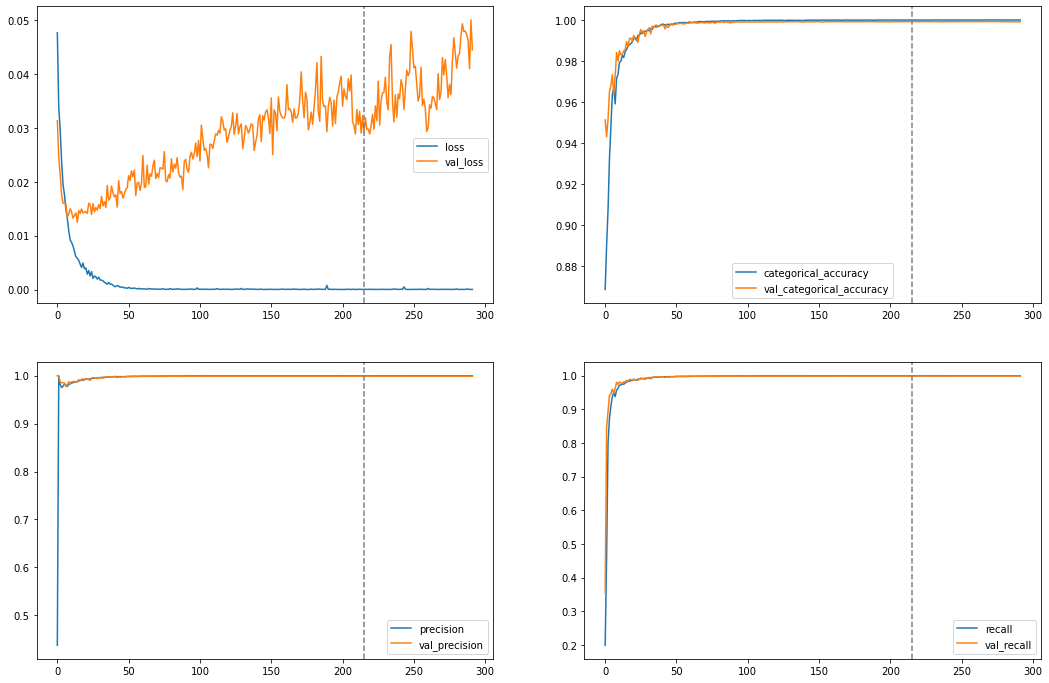

In [13]:
history = pd.read_csv(results_dir + 'history.csv')
best_idx = np.load(results_dir + 'best_idx.npy')

fig, axes = plt.subplots(2, 2, figsize=(18,12))
display(history)
history[["loss", "val_loss"]].plot(ax=axes[0,0]).axvline(x=best_idx, color='gray', linestyle='--')
history[["categorical_accuracy", "val_categorical_accuracy"]].plot(ax=axes[0,1]).axvline(x=best_idx, color='gray', linestyle='--')
history[["precision", "val_precision"]].plot(ax=axes[1,0]).axvline(x=best_idx, color='gray', linestyle='--')
history[["recall", "val_recall"]].plot(ax=axes[1,1]).axvline(x=best_idx, color='gray', linestyle='--')
plt.show()

## Mostrar metricas

,Unnamed: 0,pr_auc_macro,pr_auc_micro,f1_micro,f1_macro,f1_samples,precision_micro,precision_macro,precision_samples,recall_micro,recall_macro,recall_samples
0,0,0.096809,0.957310,0.523815,0.037584,0.354844,1.000000,0.071429,0.354844,0.354844,0.025501,0.354844
1,1,0.249318,0.977662,0.916787,0.078644,0.846592,0.999676,0.244884,0.846592,0.846592,0.068257,0.846592
2,2,0.275145,0.982426,0.938351,0.202578,0.894398,0.986848,0.226769,0.894398,0.894398,0.315164,0.894398
3,3,0.346343,0.985713,0.963199,0.243846,0.941303,0.986055,0.249112,0.941265,0.941379,0.444814,0.941379
4,4,0.341610,0.987946,0.965533,0.279898,0.946641,0.985080,0.221371,0.946587,0.946748,0.553134,0.946748
...,...,...,...,...,...,...,...,...,...,...,...,...
287,287,0.722809,0.999579,0.999065,0.715242,0.998997,0.999117,0.750544,0.998990,0.999013,0.686031,0.999013
288,288,0.756715,0.999508,0.999049,0.714684,0.998995,0.999098,0.747286,0.998993,0.999000,0.687139,0.999000
289,289,0.758919,0.999631,0.999160,0.750548,0.999089,0.999215,0.826862,0.999081,0.999104,0.712173,0.999104
290,290,0.715980,0.999625,0.999081,0.719686,0.999032,0.999117,0.752945,0.999026,0.999045,0.691737,0.999045


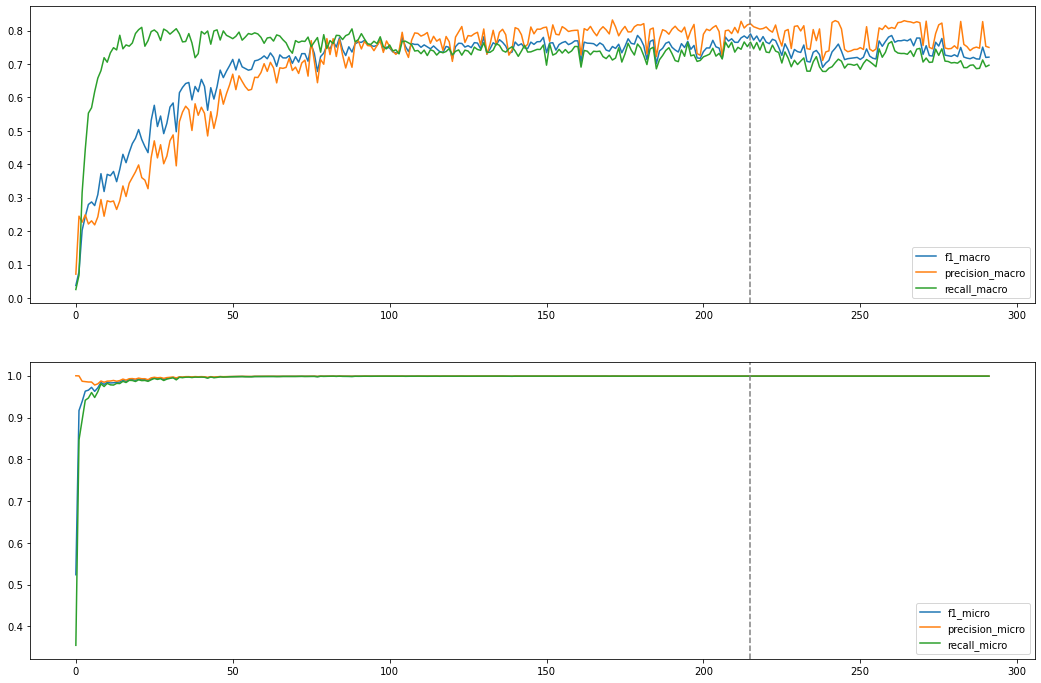

In [14]:
metricas = pd.read_csv(results_dir + 'metricas.csv')

fig, axes = plt.subplots(2, 1, figsize=(18,12))
display(metricas)
metricas[["f1_macro", "precision_macro", "recall_macro"]].plot(ax=axes[0]).axvline(x=best_idx, color="gray", linestyle="--")
metricas[["f1_micro", "precision_micro", "recall_micro"]].plot(ax=axes[1]).axvline(x=best_idx, color="gray", linestyle="--")

## Mostrar best_prediction

<AxesSubplot:>

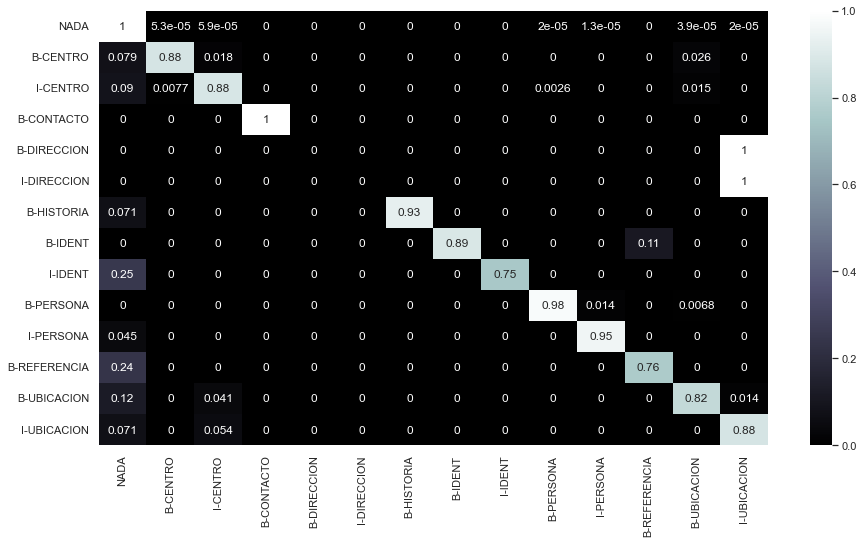

In [15]:
prediction = np.load(results_dir + 'best_prediction.npy')
best_prediction_true = np.zeros(shape=[prediction.shape[0]])
best_prediction_pred = np.zeros(shape=[prediction.shape[0]])

for i in range(prediction.shape[0]):
    best_prediction_pred[i,] = np.argmax(prediction[i,0,])
    best_prediction_true[i,] = np.argmax(prediction[i,1,])
    
sbn.set(rc = {'figure.figsize':(15,8)})

sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred, normalize="true"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

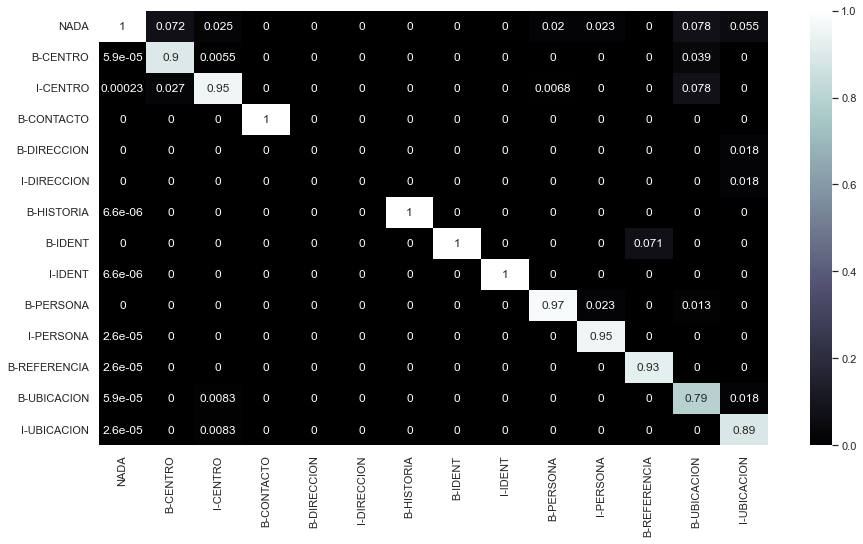

In [16]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred, normalize="pred"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

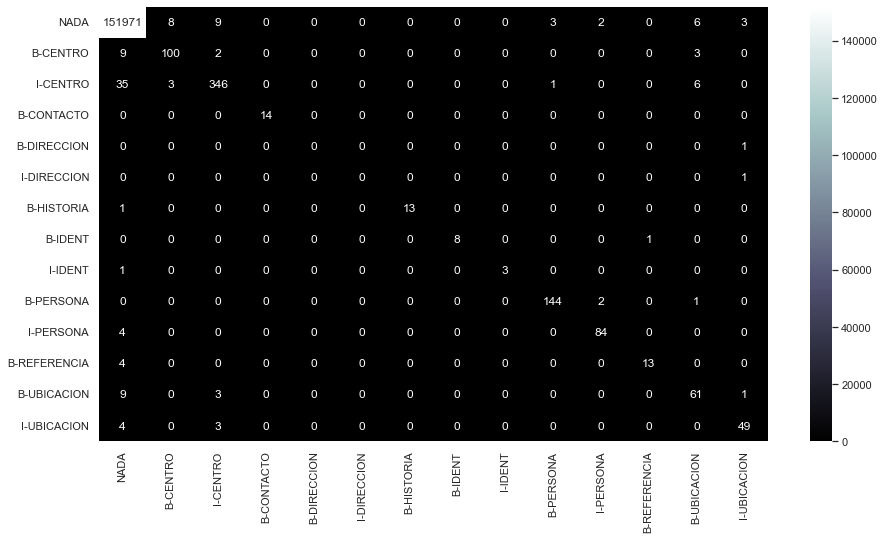

In [17]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
    fmt="d"
)

## Evaluar validación

In [18]:
# Ocultar warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

print(metrics.classification_report(best_prediction_true, best_prediction_pred, target_names=LABELS_VAL))

NameError: name 'LABELS_VAL' is not defined

## Cargar modelo

In [ ]:
# Crear una nueva instancia del modelo
model = tensorflow.keras.models.load_model(str(results_dir + 'best_model.h5'))

# Re-evaluar el modelo para todo el conjunto de test
values, prediction = evaluar_red(model, gen_test, None, threshold)
test_prediction = prediction
np.save(str(results_dir + 'test_prediction.npy'), test_prediction)

## Mostrar test_prediction

In [ ]:
test_prediction = np.load(results_dir + 'test_prediction.npy')
test_prediction_true = np.zeros(shape=[test_prediction.shape[0]])
test_prediction_pred = np.zeros(shape=[test_prediction.shape[0]])

for i in range(test_prediction.shape[0]):
    test_prediction_pred[i,] = np.argmax(test_prediction[i,0,])
    test_prediction_true[i,] = np.argmax(test_prediction[i,1,])

sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred, normalize="true"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

In [ ]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred, normalize="pred"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

In [ ]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
    fmt="d"
)

## Evaluar test 

In [ ]:
print(metrics.classification_report(test_prediction_true, test_prediction_pred, target_names=LABELS))